In [1]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import os
import richdem as rd
import cv2 as cv
import pickle

# Functions we need

In [2]:
from tensorflow.keras import backend as K

#normalization function
def normalize(x):
    num= x- x.min()
    den= x.max()-x.min()
    return num/den

#recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Prepare and explore the data

In [3]:
base_folder= r'C:\Users\serra\OneDrive\Documents\DATA\train'
TRAIN_PATH = base_folder + "\\img\*.h5"
TRAIN_MASK = base_folder + "\\mask\*.h5"

TRAIN_XX = np.zeros((3799, 128, 128, 7))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

In [ ]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):

    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001
        
        #slope and dem
        dem= data[:, :, 13]
        slope= data[:, :, 12]
        k = 5 #smoothing factor for reducing the noise
        dem_suavizado = cv.blur(dem,(k,k)) #reducción de ruido dem
        slope_suavizado = cv.blur(slope,(k,k)) #reducción de ruido slope
        
        #curvature
        dem_richdem = rd.rdarray(dem_suavizado, no_data=-9999) #convert to rdarray
        dem_curvature = rd.TerrainAttribute(dem_richdem, attrib="curvature") #calculate curvature
        dem_planform_curvature = rd.TerrainAttribute(dem_richdem, attrib="planform_curvature") #calculate planform_curvature
        dem_profile_curvature = rd.TerrainAttribute(dem_richdem, attrib="profile_curvature") #calculate profile curvature
    
        #BSI calculation
        BSI= ((data[:,:,10] + data[:,:,3]) - (data[:,:,7] + data[:,:,1]) / (data[:,:,10] + data[:,:,3]) + (data[:,:,7] + data[:,:,1]))

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        NDVI = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        # final array
        TRAIN_XX[i, :, :, 0] = dem_suavizado
        TRAIN_XX[i, :, :, 1] = slope_suavizado
        TRAIN_XX[i, :, :, 2] = dem_curvature
        TRAIN_XX[i, :, :, 3] = dem_planform_curvature
        TRAIN_XX[i, :, :, 4] = dem_profile_curvature
        TRAIN_XX[i, :, :, 5] = BSI
        TRAIN_XX[i, :, :, 6] = NDVI
    
    
    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data

In [ ]:
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001 #nan to 0.000001

In [ ]:
#Normalize each image with respect to all images from each band
TRAIN_XX[:, :, :, 0]= normalize(TRAIN_XX[:, :, :, 0])
TRAIN_XX[:, :, :, 1]= normalize(TRAIN_XX[:, :, :, 1])
TRAIN_XX[:, :, :, 2]= normalize(TRAIN_XX[:, :, :, 2])
TRAIN_XX[:, :, :, 3]= normalize(TRAIN_XX[:, :, :, 3])
TRAIN_XX[:, :, :, 4]= normalize(TRAIN_XX[:, :, :, 4])
TRAIN_XX[:, :, :, 5]= normalize(TRAIN_XX[:, :, :, 5])
TRAIN_XX[:, :, :, 6]= normalize(TRAIN_XX[:, :, :, 6])


In [5]:
# with open('bands.pickle', 'wb') as f:
#     pickle.dump(TRAIN_XX, f)
#     pickle.dump(TRAIN_YY, f)

with open('bands.pickle', 'rb') as f:
    TRAIN_XX= pickle.load(f)
    TRAIN_YY= pickle.load(f)

In [6]:
#check that the dataset is properly normalized
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

0.0 1.0 0.0 1.0


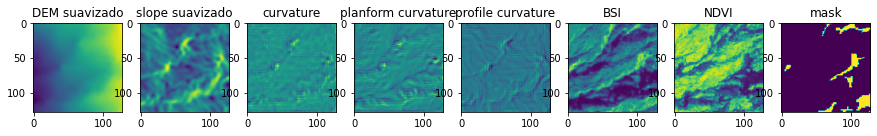

In [7]:
#plot an example
img=234
fig,(ax1,ax2, ax3, ax4, ax5, ax6, ax7, ax8)= plt.subplots(1,8,figsize=(15,10))


ax1.set_title("DEM suavizado")
ax2.set_title("slope suavizado")
ax3.set_title("curvature")
ax4.set_title("planform curvature")
ax5.set_title("profile curvature")
ax6.set_title("BSI")
ax7.set_title("NDVI")
ax8.set_title("mask")

ax1.imshow(TRAIN_XX[img, :, :, 0])
ax2.imshow(TRAIN_XX[img, :, :, 1])
ax3.imshow(TRAIN_XX[img, :, :, 2])
ax4.imshow(TRAIN_XX[img, :, :, 3])
ax5.imshow(TRAIN_XX[img, :, :, 4])
ax6.imshow(TRAIN_XX[img, :, :, 5])
ax7.imshow(TRAIN_XX[img, :, :, 6])
ax8.imshow(TRAIN_YY[img, :, :, 0])

In [8]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

In [9]:
x_train.shape, y_train.shape

((3039, 128, 128, 7), (3039, 128, 128, 1))

# SEQUENTIAL MODEL

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [51]:
#Create the model. Neural network with 3 layers.
model_sequential = Sequential()
model_sequential.add(Dense(20, input_shape=(128, 128, 7), activation='relu')) 
model_sequential.add(Dense(10, activation='relu'))
model_sequential.add(Dense(1, activation='sigmoid'))
model_sequential.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128, 128, 20)      160       
                                                                 
 dense_7 (Dense)             (None, 128, 128, 10)      210       
                                                                 
 dense_8 (Dense)             (None, 128, 128, 1)       11        
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Compile the model and set metrics
model_sequential.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy', f1_m, precision_m, recall_m])

In [54]:
#Metrics
loss, accuracy, f1_score, precision, recall = model_sequential.evaluate(x_valid, y_valid, verbose=0)
print("loss:", loss, ",", "accuracy:", accuracy, ",", "f1_score:", f1_score, ",", "precision:", precision,",", "recall:", recall)

loss: 0.045084595680236816 , accuracy: 0.9833326935768127 , f1_score: 0.5491792559623718 , precision: 0.778005063533783 , recall: 0.42835021018981934


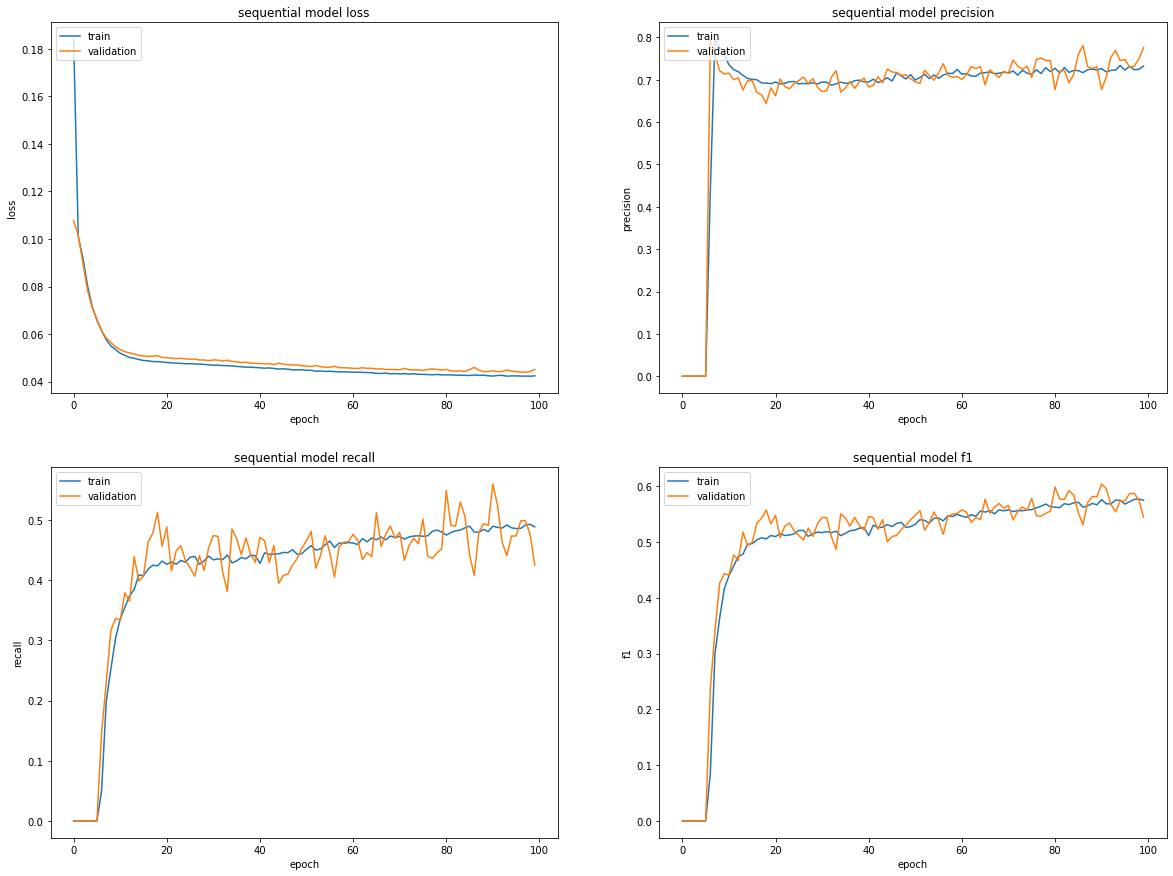

In [55]:
#Plot assessment metrics and loss
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('sequential model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('sequential model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('sequential model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('sequential model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

# UNET MODEL

In [14]:
#Highly imbalanced data
print(np.unique(TRAIN_YY, return_counts=True))

# Loss function for imbalanced data
def dice_loss(y_train, y_pred):
  y_true = tf.cast(y_train, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_train * y_pred)
  denominator = tf.reduce_sum(y_train + y_pred)

  return 1 - numerator / denominator


#Loss function for imbalanced data
def weighted_bce(y_true, y_pred):
  weights = (y_train * 42.) + 1.
  bce = K.binary_crossentropy(y_train, y_pred)
  weighted_bce = K.mean(bce * weights)
  return weighted_bce

#These loss functions are especially designed for unbalanced data, however in our model the binary_crossentropy loss function 
#performed the best.

(array([0., 1.]), array([60800026,  1442790], dtype=int64))


In [18]:
#Build the UNET model for segmentation
def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model_unet = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model_unet.compile(optimizer='adam', loss= "binary_crossentropy", metrics=['accuracy', f1_m, precision_m, recall_m])
    
    return model_unet

In [ ]:
#Run the model
model_unet = unet_model(128, 128, 7)
# model.summary()
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max") #monitor validation f1 and save the best model
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=15, verbose=1, mode='max') #avoid overfitting

callbacks = [
    earlyStopping,
    checkpointer
    ]
history = model_unet.fit(x_train, y_train, batch_size=16,  
          epochs=100, 
          verbose = 2,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

model_unet.save("model_save.h5")

In [21]:
#print metrics
loss, accuracy, f1_score, precision, recall = model_unet.evaluate(x_valid, y_valid, verbose=0)
print("loss:", loss, ",", "accuracy:", accuracy, ",", "f1_score:", f1_score, ",", "precision:", precision,",", "recall:", recall)

loss: 0.0349314883351326 , accuracy: 0.9873633980751038 , f1_score: 0.6954798102378845 , precision: 0.8053788542747498 , recall: 0.616702675819397


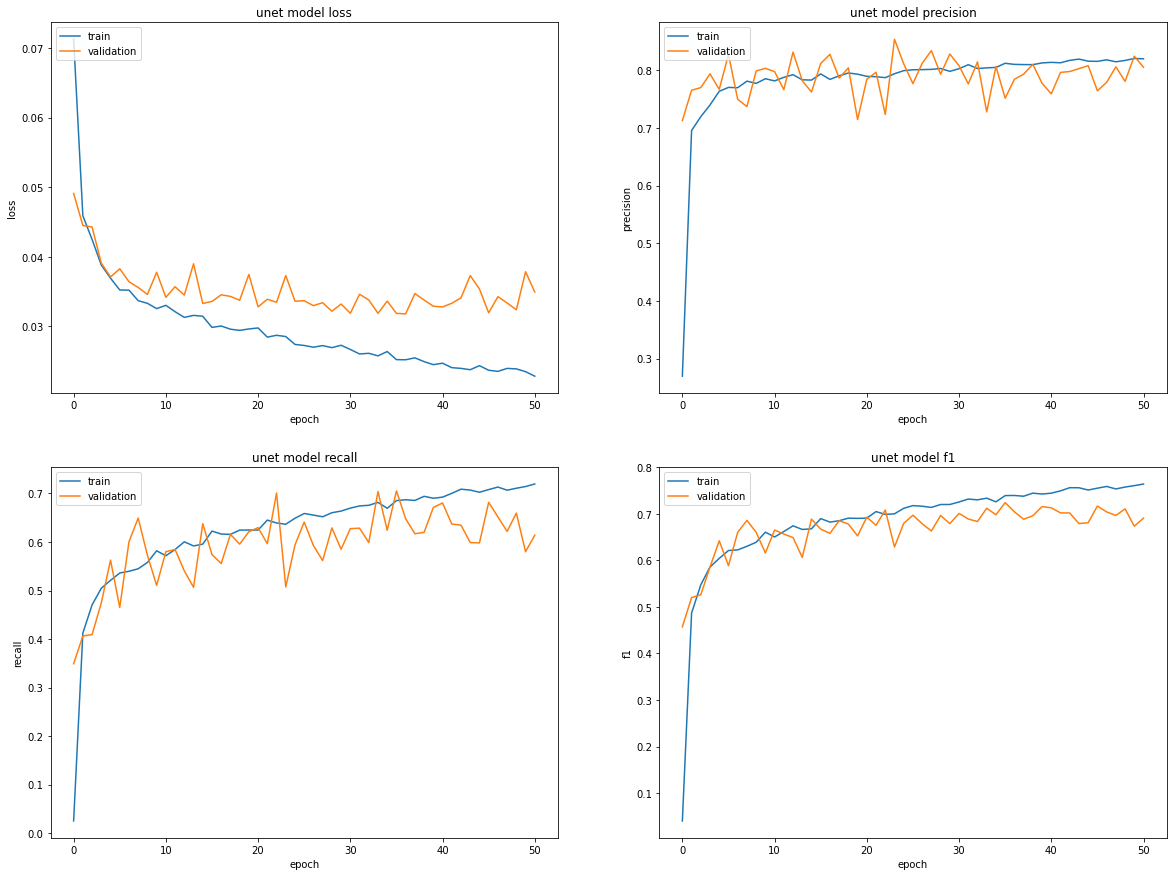

In [22]:
#plot assessment metrics and loss
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [28]:
#Compute predictions
threshold = 0.5
pred_img = model_unet.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

24/24 [==============================] - 9s 381ms/step


Text(0.5, 1.0, 'Training Image (NDVI)')

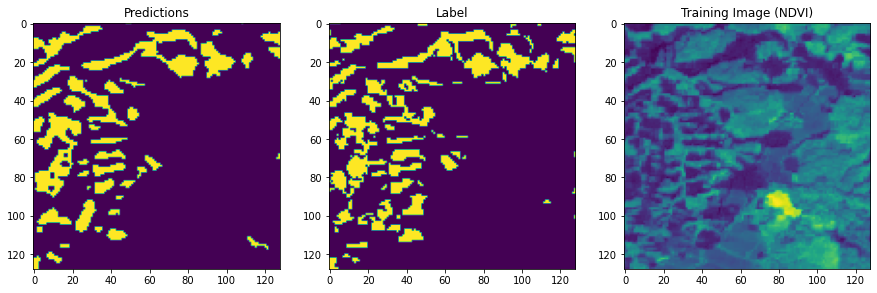

In [35]:
#Plot an example of a mask, the predictions from our UNET model and the image
img =4
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 6])
ax3.set_title('Training Image (NDVI)')